## QCD vs top tagging - unsupervised anomaly detection

### Introduction

Hadronic jets at LHC show different features according to the different particles which originate the jet.
A staple problem in High Energy Physics is the tagging of tops and QCD jets. The main difference between these two objects is the presence of a three prong structure for tops while a main single prong for QCD.

Here I show the average over 5000 images :

<p align="center">
  <img src="trained_models/img_jets_avg.png" />
</p>

A way do discriminate them is to pixelize the constituents according to their momenta in 40x40 images and then use Convolutional-based AutoEncoder to extract the main features. (2104.08291, 2104.09051)

### Task
The problem, referred as "complexity bias", is that even an AE trained on top jets is able to reconstruct a QCD jet due to the presence of similar features but with a lower coomplexity. A possible solution consist in makin the AE a probabilistic model through the implementation of an Energy Based Model called Normalized Auto Encoder. (2105.05735)

### Architecture
The architecture is based on the "Better latent spaces for better Autoencoders" paper and consists of:

**Encoder**
- Conv2d(in_dim=1, out_dim=10, kernel=5, stride=1, padding=2)
- AvgPool2d(kernel=2, scale_factor=2)
- Conv2d(10, 5, 5, 1, 2)
- Linear(2000, 100)
- Linear(100, $D_z$)

**Decoder**
- Linear($D_z$, 100)
- Linear(100, 2000)
- Upsample('nearest', 2)
- DeConv2d(5, 10, 5, 1, 2)
- DeConv2d(10, 1, 5, 1, 2)

### Performance evaluations
The performance of the models is evaluated by calculating the ROC curve and the AUC score. The ROC curve are shown with the signal efficiency (TPR) on the x-axis and the inverse backgraound efficiency (1/FPR) on the y-axis.
Additionally, for anomaly detection purpose the inverse mistag at low efficiency (0.3) is also calculated.

### NAE behavior in early epochs
I observed that the initial effect of the NAE training with the base architecture is the rising of a background which carries most of the reconstruction error. This behavior worsen the accuracy obtained after pretraining while enhance the reconstruction error of OOD samples.

The background can be mitigated by changing the activation function of the last layer as I show here with a filtered image to have a better visuzalization :

<p align="center">
  <img src="plot/img_neg_background.png" />
</p>

## Table
1. [Top tagging](#top)
    - [Reconstructed images](#top_rec)
    - [OMI sample](#top_omi)
    
2. [QCD tagging](#qcd)
    - [Reconstructed images](#qcd_rec)
    - [OMI sample](#qcd_omi)
3. [Tensorboard outputs](#tb)
    - [Top training](#tb_top)
    - [QCD training](#tb_qcd)

In [1]:
import models
from models import get_model
from omegaconf import OmegaConf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
def show(img1, img2, n_img=3, size=40, train='top', img='top', save=False):
    fig, ax = plt.subplots(n_img, 2*n_img, figsize=(4*n_img,2*n_img))
    c = 0
    for i in range(n_img):
        for j in range(n_img):
            ax[i,2*j].imshow(img1.reshape(-1, size, size)[c], aspect='auto', cmap='gist_heat_r')
            ax[i,(2*j+1)].imshow(img2.reshape(-1, size, size)[c], aspect='auto', cmap='gist_heat_r')
            ax[i, 2*j].set_xticks([]), ax[i,2*j].set_yticks([]), ax[i,(2*j+1)].set_xticks([]), ax[i,(2*j+1)].set_yticks([])
            c += 1
            ax[0, 2*j].set_title('Input')
            ax[0, (2*j+1)].set_title('Recon')
        
    plt.subplots_adjust(wspace=0.03, hspace=0.03)
    plt.suptitle(str(img) + ' images', y=0.95)

def mse_loss(x, model, size=40):
    x = torch.tensor(x, dtype=torch.float32)
    rec = model.reconstruct(x)
    return ((rec-x)**2).view(len(x), -1).mean(dim=1).detach().numpy()

def closest_point(array, tpr_p=0.3):
    dist = ((array-tpr_p)**2)
    return np.argmin(dist)

def plot_roc(mod_dirs, models, samp_size, labels, tag=1):
    assert samp_size < len(qcd_np)
    np.seterr(divide='ignore')
    fig = plt.figure(figsize=(10,8))
    for i, (mod_dir, mod) in enumerate(zip(mod_dirs, models)):
        #Load model
        conf = OmegaConf.load(mod_dir+'jet_test.yml')
        model = get_model(conf)
        state = torch.load(mod_dir+mod, map_location=torch.device('cpu'))
        if "model_state" in state:
            state = state['model_state']
        model.load_state_dict(state, strict=False)
        
        #Eval MSE
        mse_qcd = mse_loss(qcd_np[-samp_size:].astype('float32'), model.cpu())
        mse_top = mse_loss(top_np[-samp_size:].astype('float32'), model.cpu())
        if tag:
            lab = np.concatenate((np.zeros(len(mse_qcd)), np.ones(len(mse_top))))
        elif ~tag:
            lab = np.concatenate((np.ones(len(mse_qcd)), np.zeros(len(mse_top))))
        else :
            raise ValueError('tag not 0/1')
            
        scores = np.concatenate((mse_qcd, mse_top))
        fpr, tpr, th = roc_curve(lab, scores)
        plt.plot(tpr, 1/fpr, label='AUC: {:.3f}, $\epsilon_s(0.3)$= {:.0f}, '.format(roc_auc_score(lab, scores), 1/fpr[closest_point(tpr)])+labels[i])
    plt.hlines(y=np.linspace(1,10, 10), xmin=0, xmax=1, color='grey', linewidth=0.2, alpha=0.4)
    plt.hlines(y=np.linspace(10,100, 10), xmin=0, xmax=1, color='grey', linewidth=0.2, alpha=0.4)
    plt.hlines(y=np.linspace(100,1000, 10), xmin=0, xmax=1, color='grey', linewidth=0.2, alpha=0.4)
    plt.plot(np.linspace(0,1,50), 1/np.linspace(0,1,50), color='black')
    
    plt.yscale('log')
    plt.xlabel('$\epsilon_{sig}$', fontsize=12)
    plt.ylabel('$1/\epsilon_{bkg}$', fontsize=12)
    plt.legend()

In [3]:
qcd_jets = './datasets/train.img40X40.crop.rot.flip.norm.bkg.correct.h5'
qcd_data = pd.read_hdf(qcd_jets, key='table')
is_sig = qcd_data.pop('is_signal_new')
mass = qcd_data.pop('mass')

qcd_np = qcd_data.iloc[:, :1600].to_numpy().reshape(-1,1,40,40)

In [4]:
top_jets = './datasets/train.img40X40.crop.rot.flip.norm.sig.correct.h5'
top_data = pd.read_hdf(top_jets, key='table')
is_sig_top = top_data.pop('is_signal_new')
top_mass = top_data.pop('mass')

top_np = top_data.iloc[:, :1600].to_numpy().reshape(-1,1,40,40)

### top tagging <a name='top'>
    
#### Reconstruction <a name='top_rec'>
    
The first easy scenario is for top tagging. In this case, due to the complexity bias, the pre-trained model is already a good starting point for the anomaly detection since the more complex jet structure of tops is not reconstructed.

Starting from an AUC of $\simeq$0.8, the NAE slightly improves the result using the PReLU activation up to 0.91 and then it decreases again in the next iterations. No particular improvements have been found using the sigmoid.

Here I show some reconstructed images for both classes and the ROC curve for the validation dataset.

In [5]:
res_top_dir = 'trained_models/top_tagging/'

cfg = OmegaConf.load(res_top_dir + 'jet_test.yml')
model = get_model(cfg)

state = torch.load(res_top_dir+'nae_iter_3001.pkl', map_location=torch.device('cpu'))
if 'model_state' in state:
    state = state['model_state']
model.load_state_dict(state, strict=False)

qcd_imgs = qcd_np[-36:].reshape(-1,1,40,40)
qcd_rec_imgs = model.reconstruct(torch.tensor(qcd_imgs, dtype=torch.float32)).detach().numpy()

top_imgs = top_np[-36:].reshape(-1,1,40,40)
top_rec_imgs = model.reconstruct(torch.tensor(top_imgs, dtype=torch.float32)).detach().numpy()

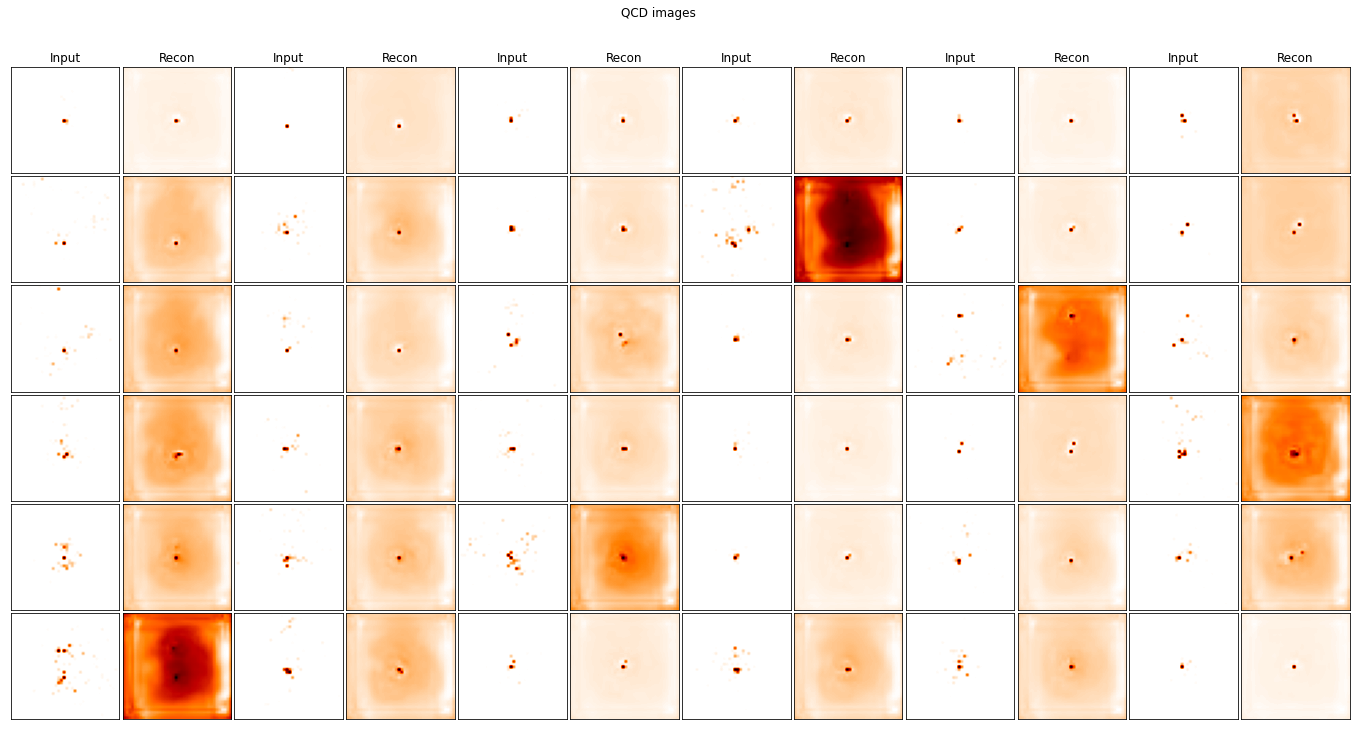

In [6]:
show(qcd_imgs, qcd_rec_imgs, n_img=6, size=40, img='QCD')

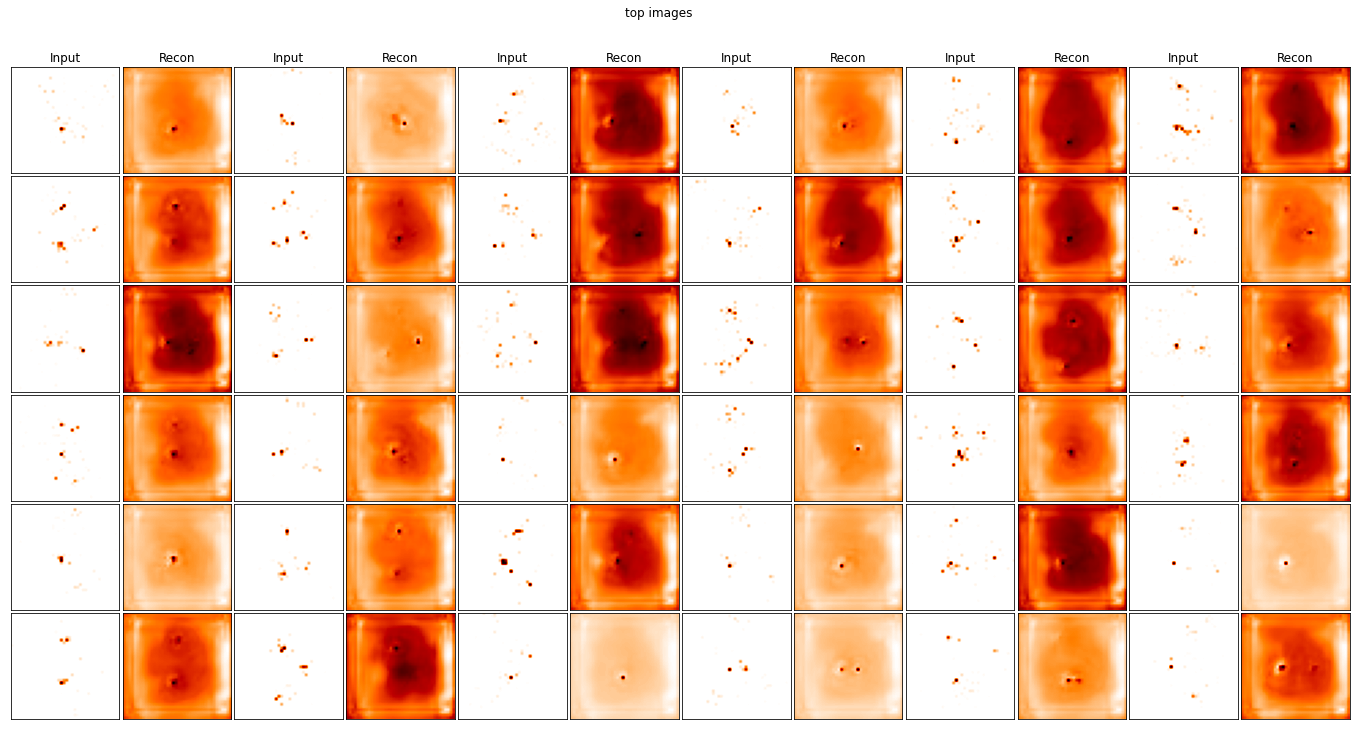

In [7]:
show(top_imgs, top_rec_imgs, n_img=6, size=40, img='top')

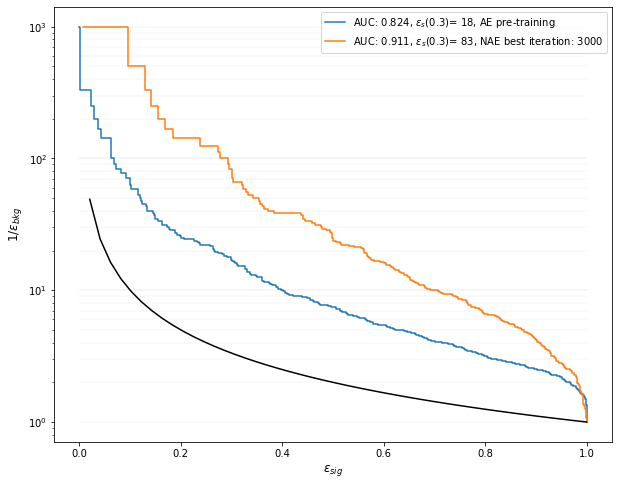

In [8]:
plot_roc((res_top_dir, res_top_dir,), ('model_best.pkl', 'nae_iter_3001.pkl',), 1000, labels=('AE pre-training', 'NAE best iteration: 3000'))

#### **OMI sample** <a name='top_omi'>

The next plot shows a batch of images after OMI and the average image of the whole batch.
From the last plot we can check that the sample covers the modes of the input space and that resemble the training distribution.

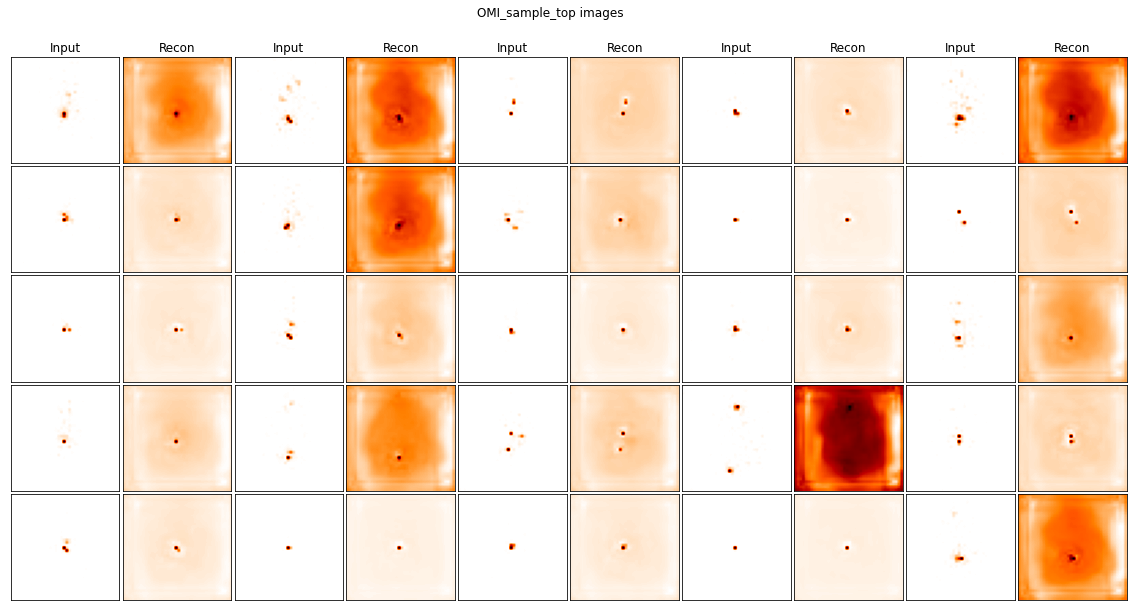

In [22]:
neg = np.load(res_top_dir+'nae_neg_3001.npy')
neg_rec = np.load(res_top_dir+'nae_neg_recon_3001.npy')

show(neg, neg_rec, n_img=5, size=40, img='OMI_sample_top')

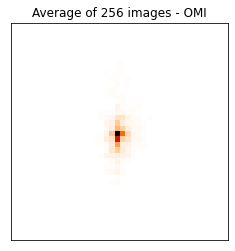

In [23]:
avg_top_omi = neg.mean(axis=0).reshape(40,40)
plt.imshow(avg_top_omi, cmap='gist_heat_r')
plt.xticks([])
plt.yticks([])
plt.title("Average of 256 images - OMI")
plt.show()

### QCD tagging <a name='qcd'>
#### Reconstructed images <a name='qcd_rec'>
  
The inverse tagging problem is indeed the main reason for a probabilistic AE. In this case, the much more simple structure allows the top-trained AE to reconstruct QCD images even if they are not in the training sample.

The starting AUC is $\simeq$0.3 and the NAE is only capable to push this at $\simeq$0.5 again with the negative background.

In [12]:
res_qcd_dir = 'trained_models/qcd_tagging/'

cfg = OmegaConf.load(res_qcd_dir + 'jet_test.yml')
model = get_model(cfg)

state = torch.load(res_qcd_dir+'nae.pkl', map_location=torch.device('cpu'))
if 'model_state' in state:
    state = state['model_state']
model.load_state_dict(state, strict=False)

qcd_imgs = qcd_np[-36:].reshape(-1,1,40,40)
qcd_rec_imgs = model.reconstruct(torch.tensor(qcd_imgs, dtype=torch.float32)).detach().numpy()

top_imgs = top_np[-36:].reshape(-1,1,40,40)
top_rec_imgs = model.reconstruct(torch.tensor(top_imgs, dtype=torch.float32)).detach().numpy()

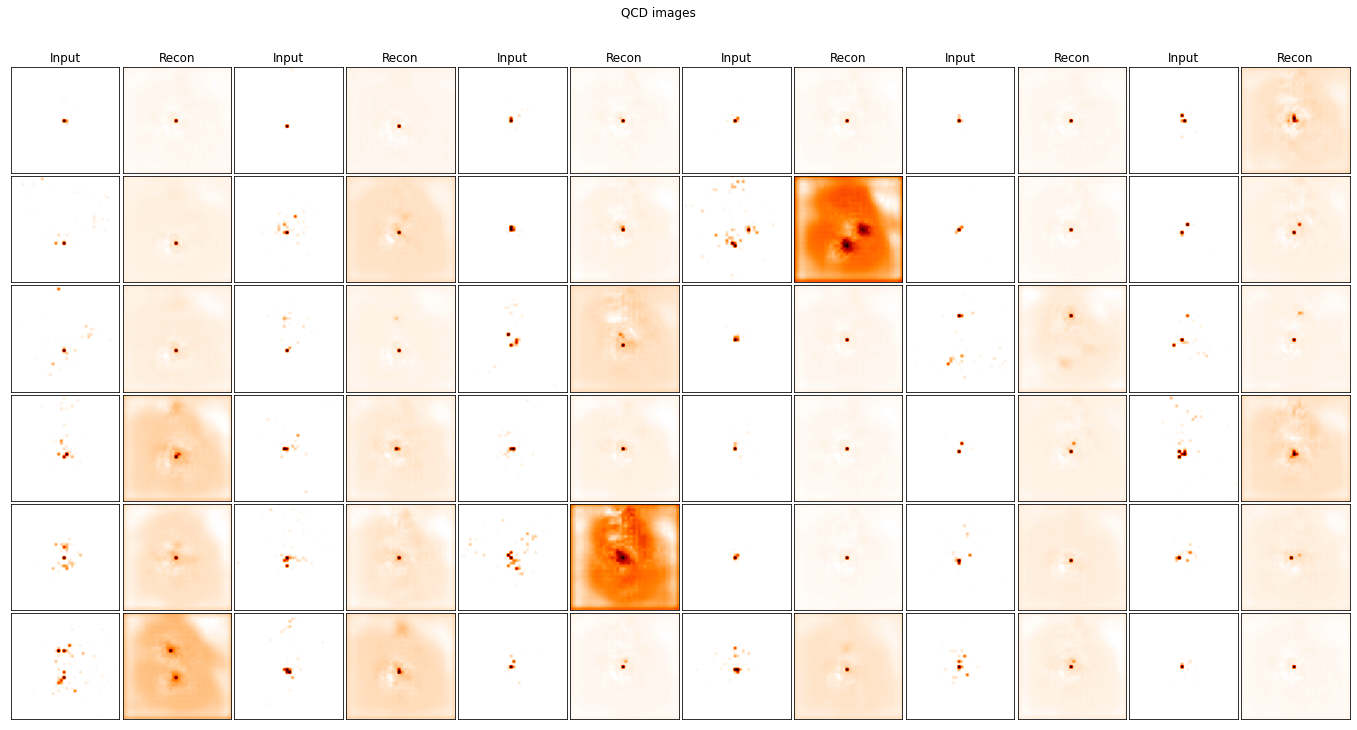

In [13]:
show(qcd_imgs, qcd_rec_imgs, n_img=6, size=40, img='QCD')

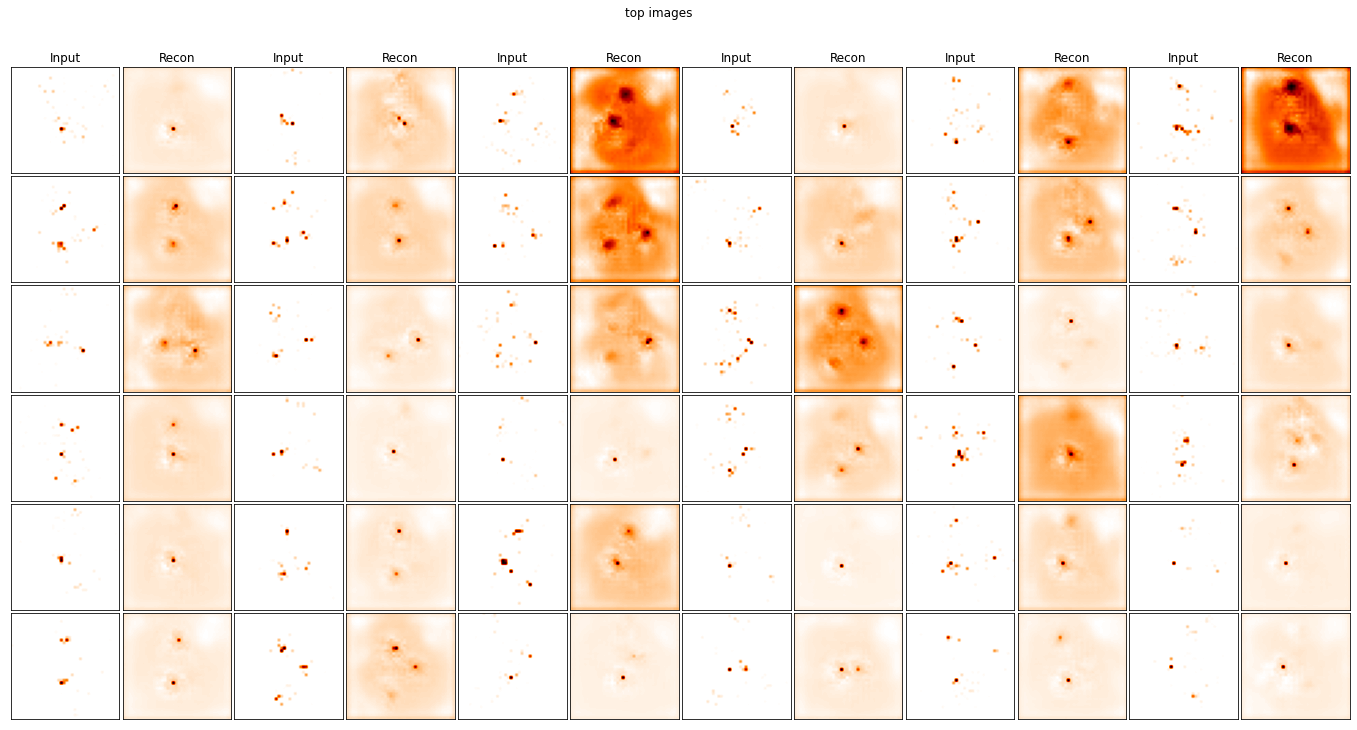

In [14]:
show(top_imgs, top_rec_imgs, n_img=6, size=40, img='top')

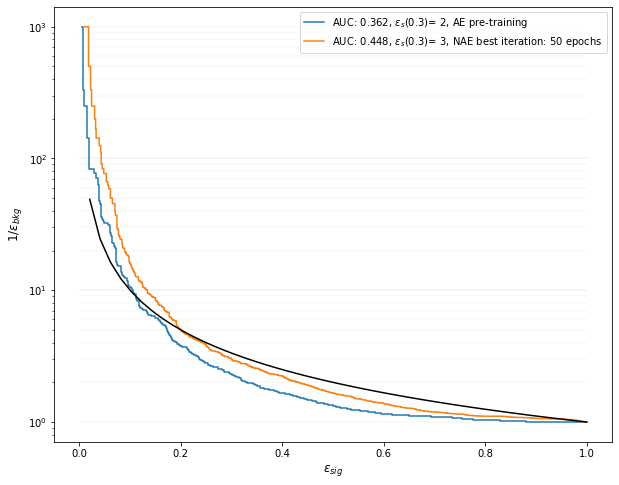

In [16]:
plot_roc((res_qcd_dir, res_qcd_dir,), ('model_best.pkl', 'nae.pkl',), 1000, labels=('AE pre-training', 'NAE best iteration: 50 epochs'), tag=0)

#### OMI sample <a name='qcd_omi'>

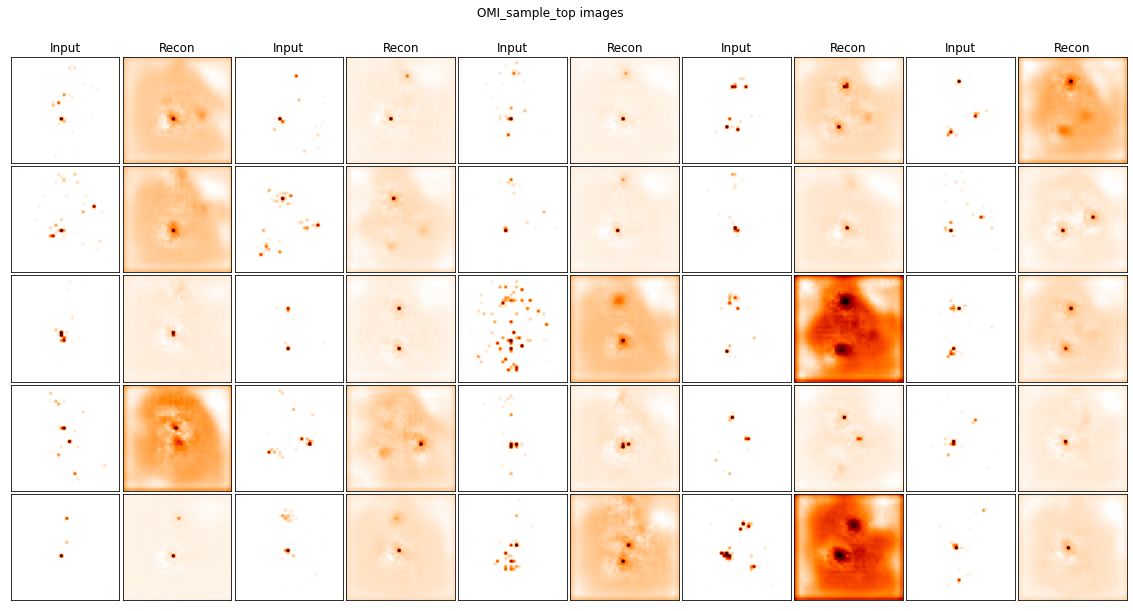

In [18]:
neg = np.load(res_qcd_dir+'nae_neg_39001.npy')
neg_rec = np.load(res_qcd_dir+'nae_neg_recon_39001.npy')

show(neg, neg_rec, n_img=5, size=40, img='OMI_sample_top')

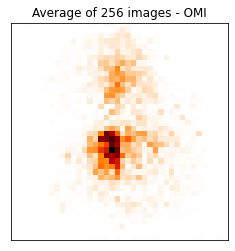

In [20]:
avg_top_omi = neg.mean(axis=0).reshape(40,40)
plt.imshow(avg_top_omi, cmap='gist_heat_r')
plt.xticks([])
plt.yticks([])
plt.title("Average of 256 images - OMI")
plt.show()

### Tensorboard plots <a name='tb'/>

This section resumes the plots from Tensorboard for the two models presented above.
For each training, I show the AUC, the weights norm for both encoder and decoder, the loss function, and the energies from the positive an negative samples.
    

#### top training <a name='tb_top'/>

<p align="center">
  <img src="trained_models/top_auc.png" />
</p>
<p align="center">
  <img src="trained_models/top_encoder.png" />
</p>
<p align="center">
  <img src="trained_models/top_decoder.png" />
</p>
<p align="center">
  <img src="trained_models/top_loss_function.png" />
</p>
<p align="center">
  <img src="trained_models/top_negenergy.png" />
</p>
<p align="center">
  <img src="trained_models/top_posenergy.png" />
</p>

#### QCD training <a name='tb_qcd'/>

<p align="center">
  <img src="trained_models/qcd_auc.png" />
</p>
<p align="center">
  <img src="trained_models/qcd_encoder.png" />
</p>
<p align="center">
  <img src="trained_models/qcd_decoder.png" />
</p>
<p align="center">
  <img src="trained_models/qcd_loss_function.png" />
</p>
<p align="center">
  <img src="trained_models/qcd_negenergy.png" />
</p>
<p align="center">
  <img src="trained_models/qcd_posenergy.png" />
</p>